### Load data

There are 3 datasets with quarterly data and 6 with monthly so we will transform the quarterly data into monthly.

In [1580]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.filters.hp_filter import hpfilter



In [1581]:
# Load data with datetime conversion
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df


# Banking data
df_money_credit = load_data('../data/banking/money_credit.csv')
df_loan_interest = load_data('../data/banking/loan_interest.csv')
df_reserve_assets = load_data('../data/banking/reserve_assets.csv')

# Housing data
df_construction_costs = load_data('../data/housing/construction_costs.csv')
# df_house_prices = load_data('../data/housing/house_prices.csv')
df_rent_prices = load_data('../data/housing/rent_prices.csv')


In [1582]:
# Load quarterly data
def load_quarterly_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df


# Labour data
df_ulc_quarterly = load_quarterly_data('../data/labour/unit_labour_costs.csv')
df_lsi_quarterly = load_quarterly_data('../data/labour/labour_share_of_income.csv')
df_alch_quarterly = load_quarterly_data('../data/labour/average_compensation_per_hour.csv')

# Housing data
df_house_prices_quarterly = load_quarterly_data('../data/housing/house_prices.csv')

# Resample quarterly data to monthly using forward fill
df_ulc = df_ulc_quarterly.resample('ME').ffill()
df_lsi = df_lsi_quarterly.resample('ME').ffill()
df_alch = df_alch_quarterly.resample('ME').ffill()

df_house_prices = df_house_prices_quarterly.resample('ME').ffill()

### Use same time period across all data

In [1583]:
# Step 1: Find the overlapping date range across all dataframes
start_date = max(df.index.min() for df in [
    df_money_credit, df_loan_interest, df_reserve_assets,
    df_ulc, df_lsi, df_alch,
    df_construction_costs, df_house_prices, df_rent_prices
])

end_date = min(df.index.max() for df in [
    df_money_credit, df_loan_interest, df_reserve_assets,
    df_ulc, df_lsi, df_alch,
    df_construction_costs, df_house_prices, df_rent_prices
])


# Step 2: Filter each DataFrame by this date range
def filter_by_date_range(df, start, end):
    return df.loc[start:end]


df_money_credit = filter_by_date_range(df_money_credit, start_date, end_date)
df_loan_interest = filter_by_date_range(df_loan_interest, start_date, end_date)
df_reserve_assets = filter_by_date_range(df_reserve_assets, start_date, end_date)

df_ulc = filter_by_date_range(df_ulc, start_date, end_date)
df_lsi = filter_by_date_range(df_lsi, start_date, end_date)
df_alch = filter_by_date_range(df_alch, start_date, end_date)

df_construction_costs = filter_by_date_range(df_construction_costs, start_date, end_date)
df_house_prices = filter_by_date_range(df_house_prices, start_date, end_date)
df_rent_prices = filter_by_date_range(df_rent_prices, start_date, end_date)

### Helpers

In [1584]:
def detrend_data(df, column):
    # Percentage change
    df[f'{column}_pct_change'] = df[column].pct_change() * 100

    # HP Filter
    cycle, _ = hpfilter(df[column], lamb=14400)
    df[f'{column}_hp_cycle'] = cycle
    return df

In [1585]:
def plot_detrended_data(df, original_column, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[original_column], label='Original Data')
    # plt.plot(df.index, df[f'{original_column}_pct_change'], label='Percentage Change', linestyle='--')
    plt.plot(df.index, df[f'{original_column}_hp_cycle'], label='HP Filter Cycle', linestyle=':')
    plt.title(f'{title}: Original and Detrended')
    plt.xlabel('Date')
    plt.ylabel(original_column)
    plt.legend()
    plt.grid(True)
    plt.show()


### Banking

In [1586]:
# Detrend the relevant columns in each dataframe for banking sector
df_money_credit = detrend_data(df_money_credit, 'Money')
df_money_credit = detrend_data(df_money_credit, 'Lending')

df_loan_interest = detrend_data(df_loan_interest, 'Loan interests average percentage')
df_loan_interest = detrend_data(df_loan_interest, 'Deposit interest average percentage')

df_reserve_assets = detrend_data(df_reserve_assets, 'UK Total Reserve Assets')
df_reserve_assets = detrend_data(df_reserve_assets, 'UK Total Liabilities')


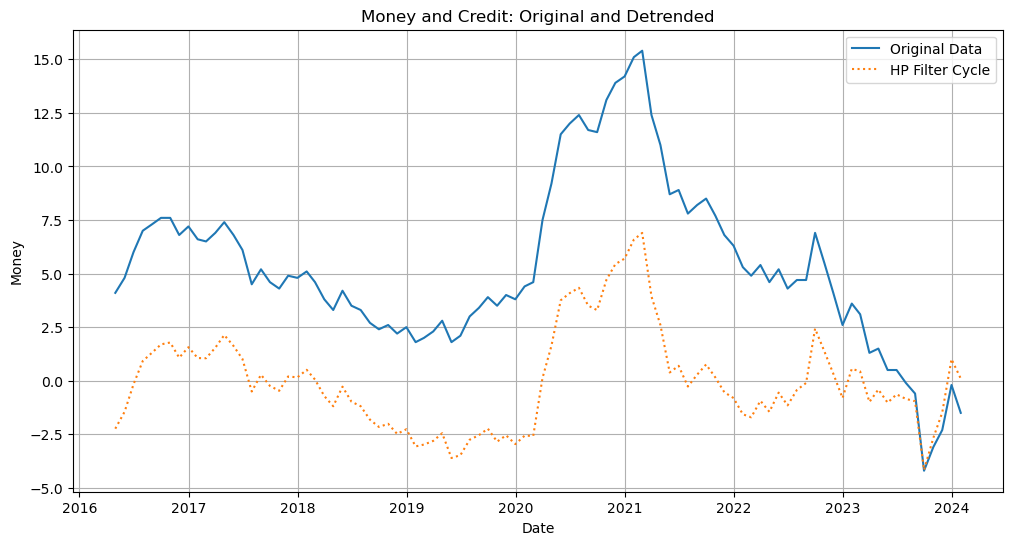

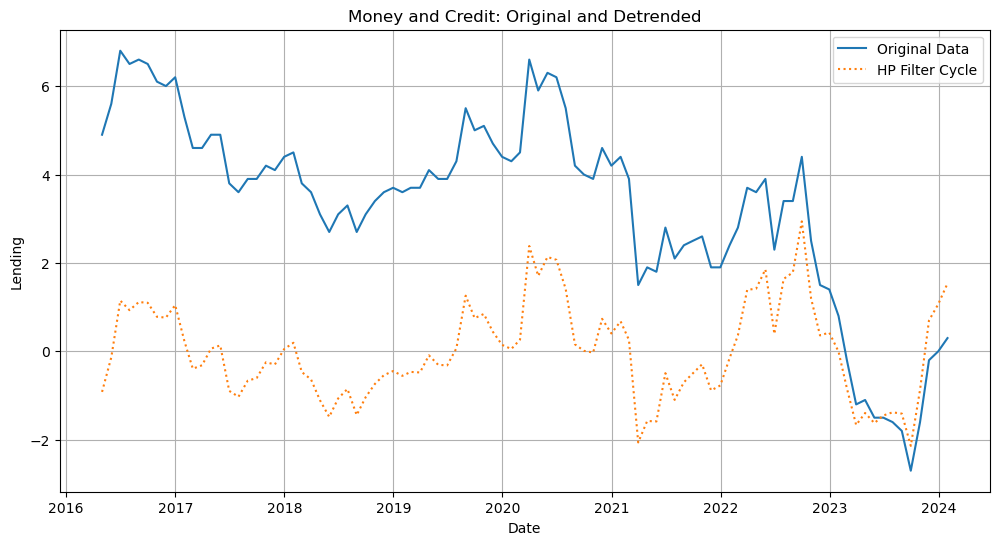

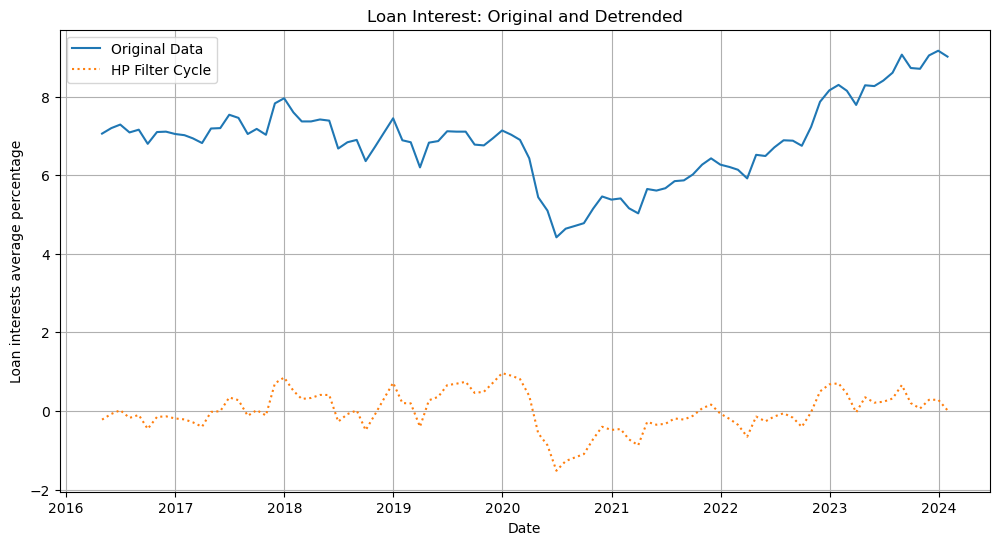

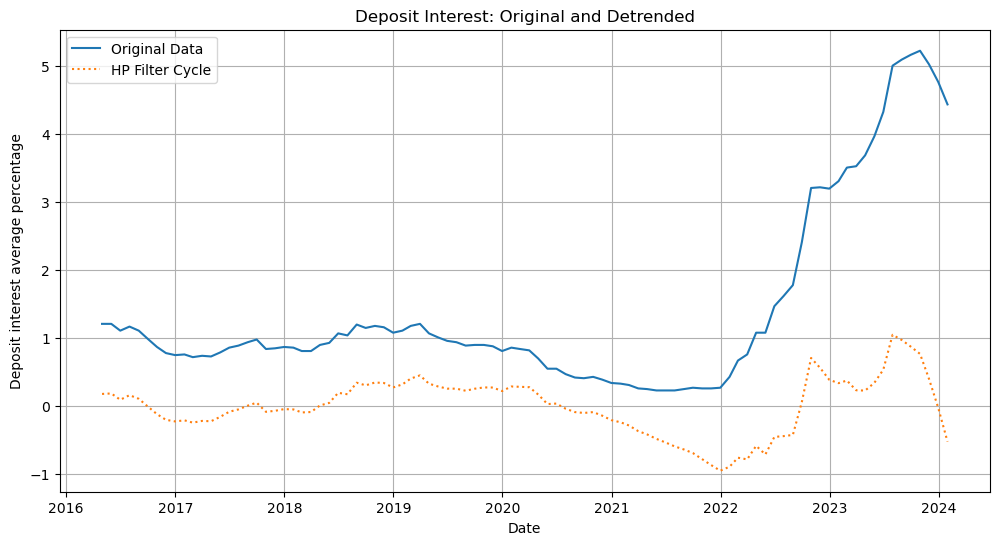

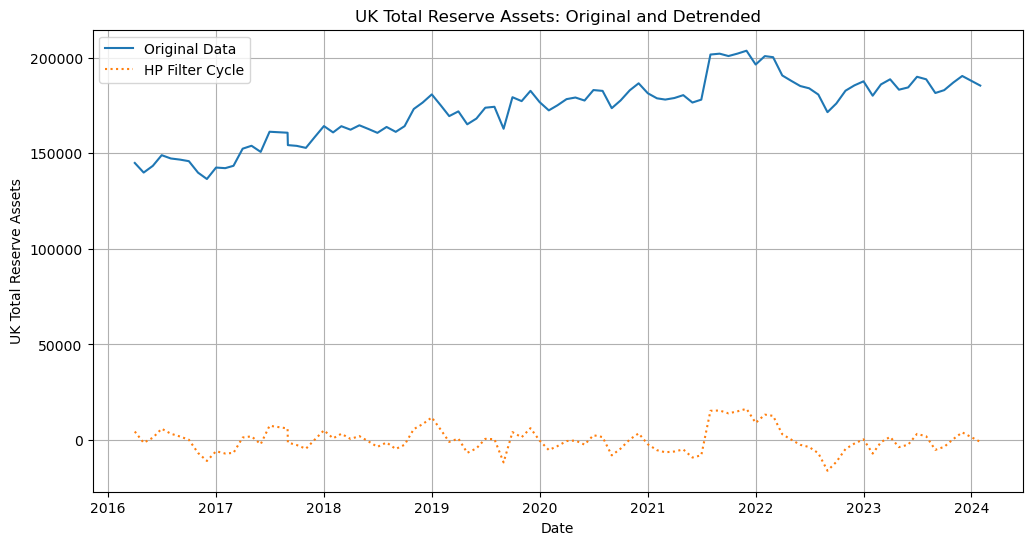

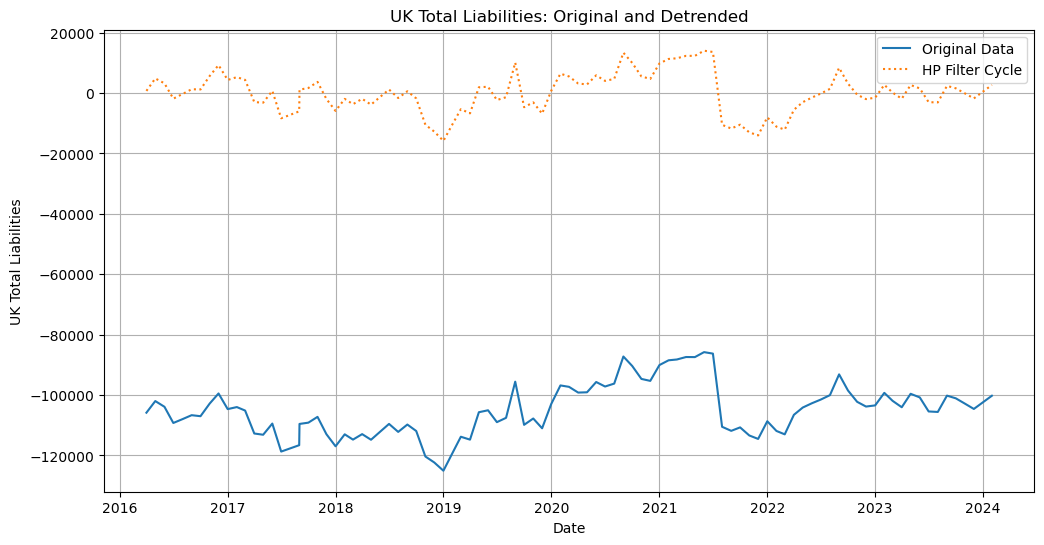

In [1587]:
plot_detrended_data(df_money_credit, 'Money', 'Money and Credit')
plot_detrended_data(df_money_credit, 'Lending', 'Money and Credit')

plot_detrended_data(df_loan_interest, 'Loan interests average percentage', 'Loan Interest')
plot_detrended_data(df_loan_interest, 'Deposit interest average percentage', 'Deposit Interest')

plot_detrended_data(df_reserve_assets, 'UK Total Reserve Assets', 'UK Total Reserve Assets')
plot_detrended_data(df_reserve_assets, 'UK Total Liabilities', 'UK Total Liabilities')


### Labour

In [1588]:
# Detrend the relevant columns in each dataframe for labour sector
df_ulc = detrend_data(df_ulc, 'Whole economy')
df_lsi = detrend_data(df_lsi, 'Whole economy')
df_alch = detrend_data(df_alch, 'Whole economy')


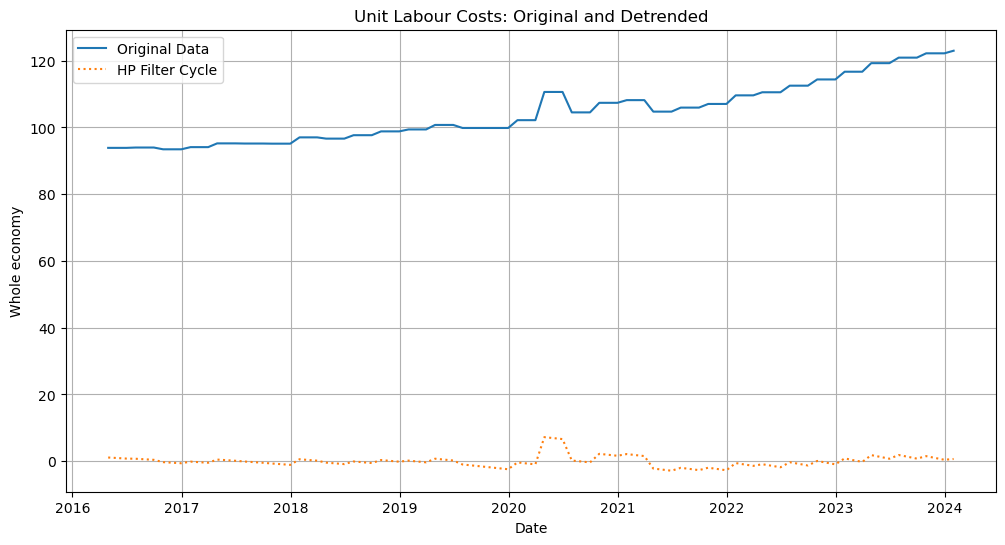

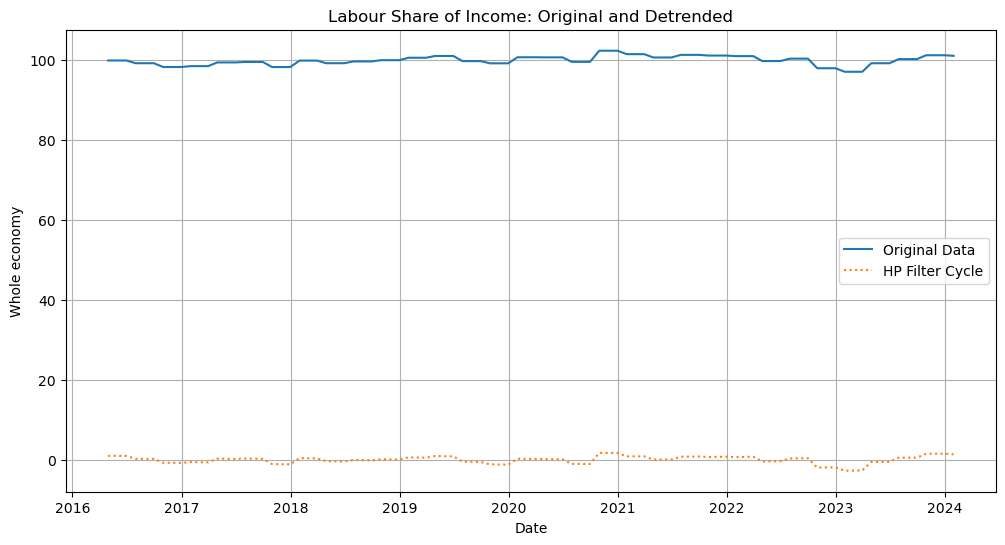

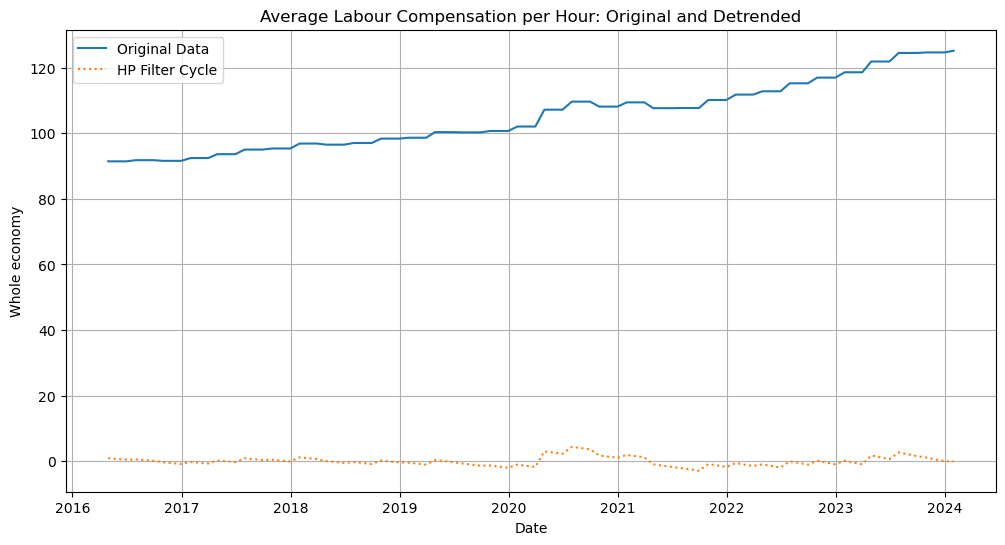

In [1589]:
# Example for each domain
plot_detrended_data(df_ulc, 'Whole economy', 'Unit Labour Costs')
plot_detrended_data(df_lsi, 'Whole economy', 'Labour Share of Income')
plot_detrended_data(df_alch, 'Whole economy', 'Average Labour Compensation per Hour')

### Housing

In [1590]:
# Detrend the relevant columns in each dataframe for housing sector
df_house_prices = detrend_data(df_house_prices, 'House Price')
df_house_prices = detrend_data(df_house_prices, 'Buyers income')

df_rent_prices = detrend_data(df_rent_prices, 'Rental price')

df_construction_costs = detrend_data(df_construction_costs, 'Construction Price Index')
df_construction_costs = detrend_data(df_construction_costs, 'Repair Price Index')


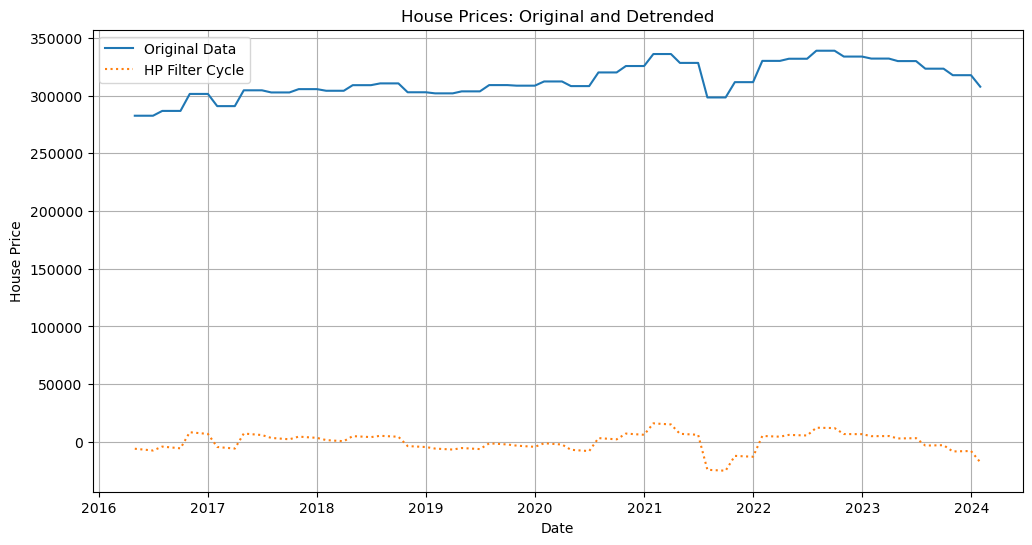

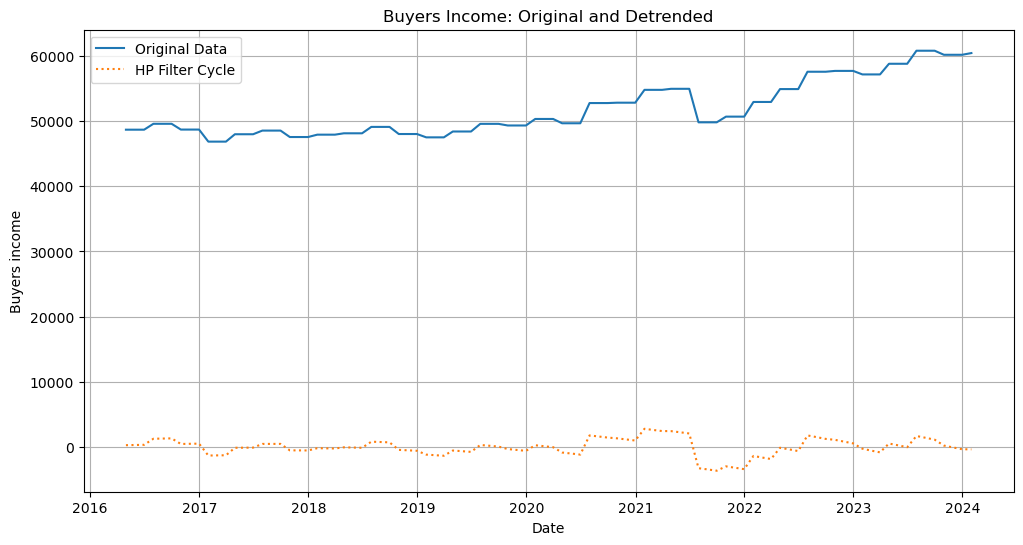

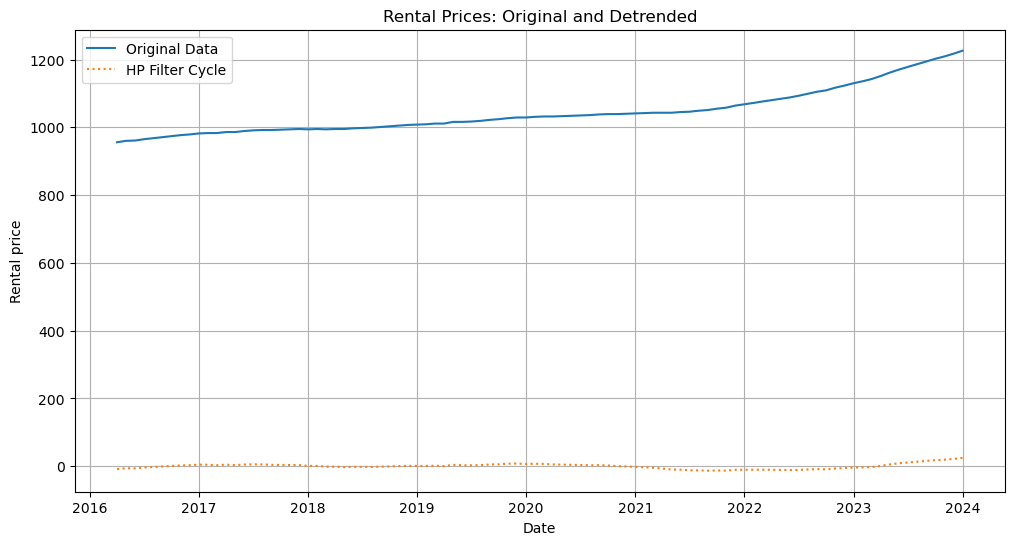

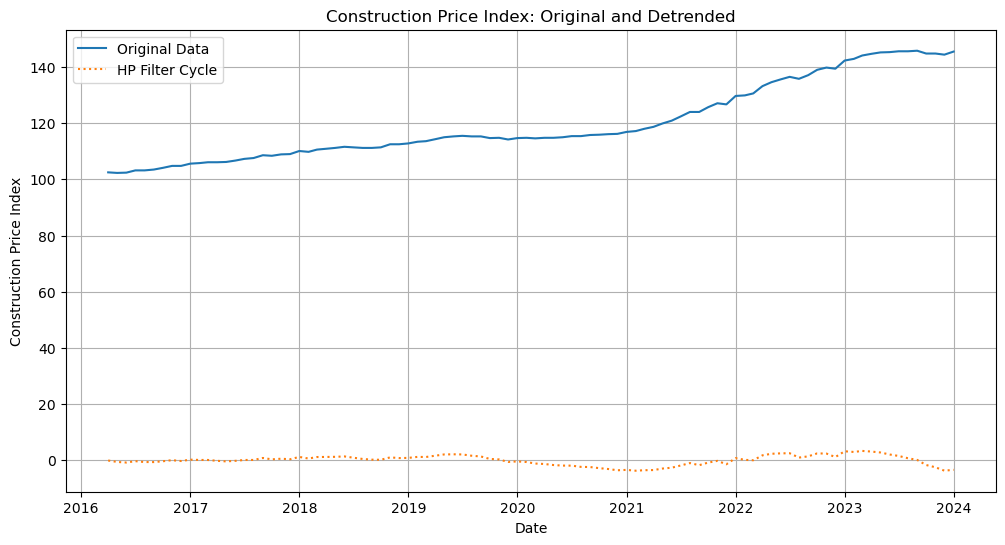

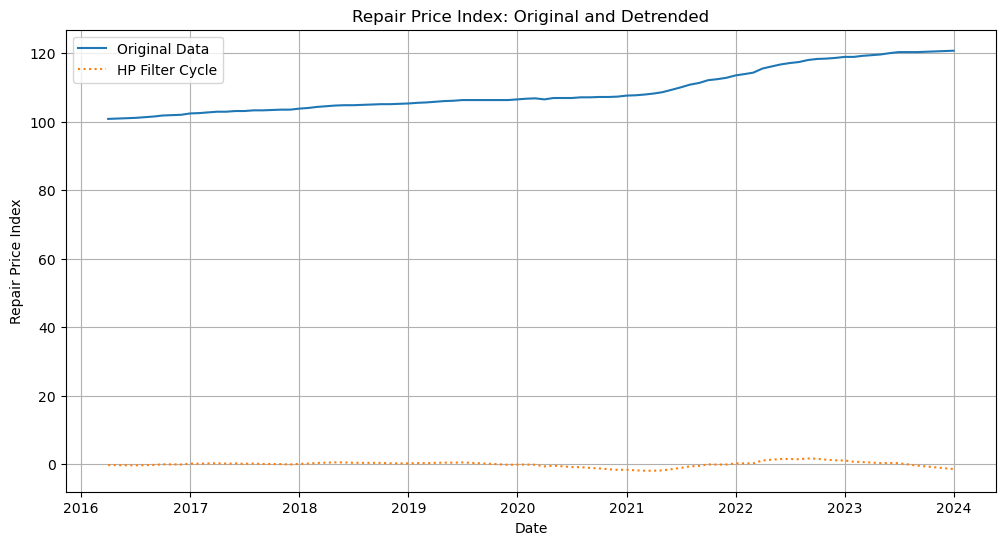

In [1591]:
plot_detrended_data(df_house_prices, 'House Price', 'House Prices')
plot_detrended_data(df_house_prices, 'Buyers income', 'Buyers Income')
plot_detrended_data(df_rent_prices, 'Rental price', 'Rental Prices')
plot_detrended_data(df_construction_costs, 'Construction Price Index', 'Construction Price Index')
plot_detrended_data(df_construction_costs, 'Repair Price Index', 'Repair Price Index')



### Correlation

In [1592]:
# Normalize all dates to the last day of the month
for df in [df_money_credit, df_loan_interest, df_reserve_assets,
           df_ulc, df_lsi, df_alch,
           df_construction_costs, df_house_prices, df_rent_prices]:
    # Convert to PeriodIndex and back to DatetimeIndex for the last day of the month
    df.index = df.index.to_period('M').end_time

# Step 1: Align and merge detrended data
# Create an initial DataFrame with the date index from the banking data
df_corr = df_money_credit[['Money_hp_cycle', 'Lending_hp_cycle']].copy()

# Merge other datasets by their index (Date)
df_corr = df_corr.join(
    df_loan_interest[['Loan interests average percentage_hp_cycle', 'Deposit interest average percentage_hp_cycle']],
    how='inner', rsuffix='_interest')
df_corr = df_corr.join(df_reserve_assets[['UK Total Reserve Assets_hp_cycle']], how='inner', rsuffix='_reserve')

# Labour sector
df_corr = df_corr.join(df_ulc[['Whole economy_hp_cycle']], how='inner', rsuffix='_ulc')
df_corr = df_corr.join(df_lsi[['Whole economy_hp_cycle']], how='inner', rsuffix='_lsi')
df_corr = df_corr.join(df_alch[['Whole economy_hp_cycle']], how='inner', rsuffix='_alch')

# Housing sector
df_corr = df_corr.join(df_house_prices[['House Price_hp_cycle', 'Buyers income_hp_cycle']], how='inner',
                       rsuffix='_house')
df_corr = df_corr.join(df_rent_prices[['Rental price_hp_cycle']], how='inner', rsuffix='_rent')
df_corr = df_corr.join(df_construction_costs[['Construction Price Index_hp_cycle', 'Repair Price Index_hp_cycle']],
                       how='inner', rsuffix='_construction')
# 
df_corr.to_csv('../data/merged.csv', index=True)


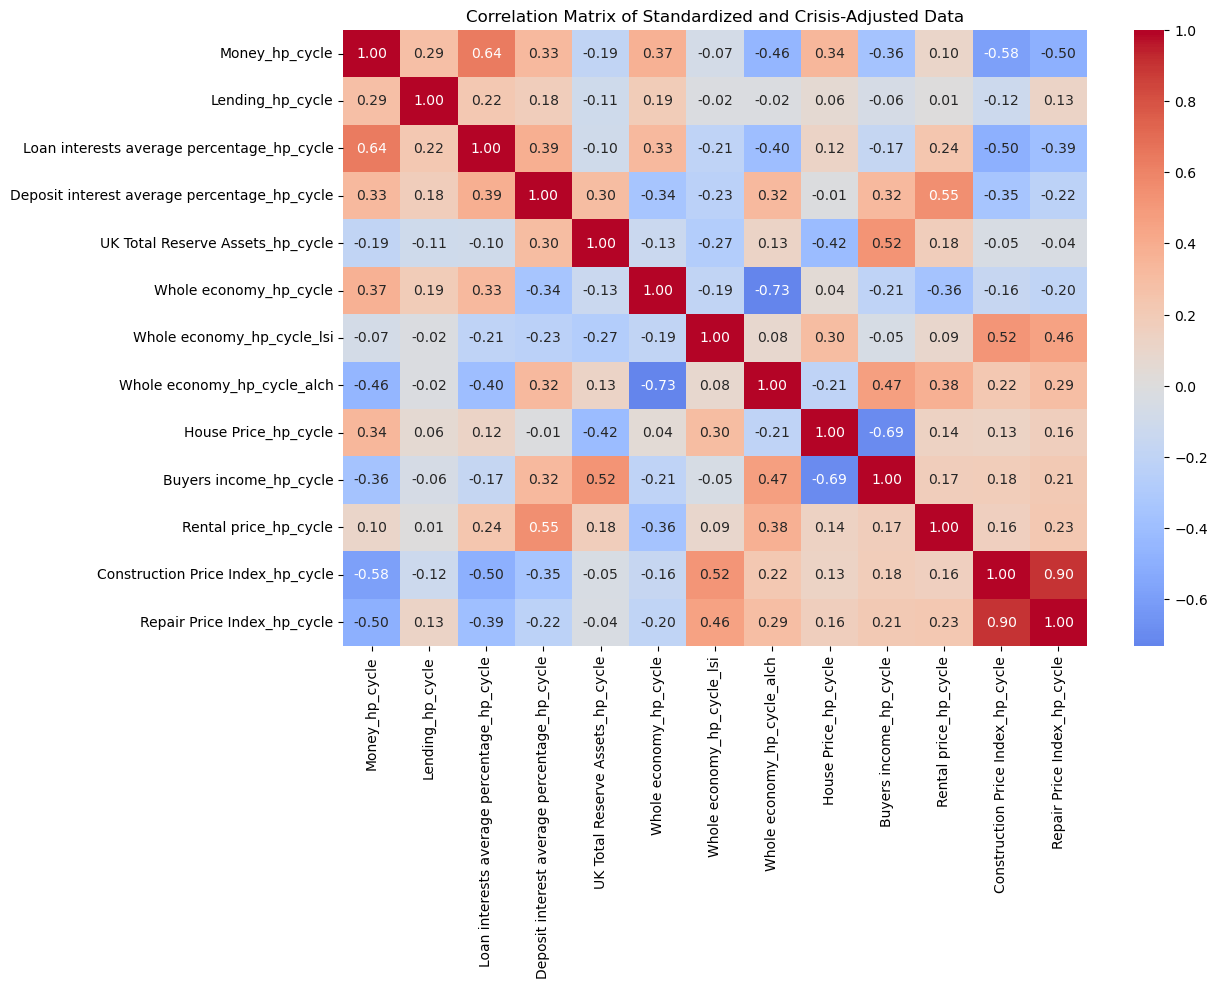

In [1593]:
df_corr = pd.read_csv('../data/merged.csv', index_col=0)

# Standardize the data
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_corr), columns=df_corr.columns, index=df_corr.index)

# Identify columns where high values represent non-crisis, to invert them
# For example, assuming 'Money_hp_cycle' and 'Lending_hp_cycle' need inversion
# based on the assumption that higher values signify non-crisis periods.
columns_to_invert = [
    'Money_hp_cycle', 
    'Lending_hp_cycle', 
    'UK Total Reserve Assets_hp_cycle',
    'Whole economy_hp_cycle',
    'House Price_hp_cycle',
    'Construction Price Index_hp_cycle', 'Repair Price Index_hp_cycle'
]

# Invert the selected columns
df_standardized[columns_to_invert] = -df_standardized[columns_to_invert]

# Recalculate correlation matrix after transformations
correlation_matrix_standardized = df_standardized.corr()

# Plot the new correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_standardized, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix of Standardized and Crisis-Adjusted Data")
plt.show()

In this case, standardization is more suitable than normalization (scaling to a 0-1 range) because of the following reasons:

1. Data Distribution and Symmetry:

    Standardization centers the data around a mean of 0 and scales it to unit variance, preserving the shape of the data distribution. This is especially useful when working with data that could be normally distributed or have both positive and negative values, as with economic indicators in the dataset.
    Normalization, on the other hand, compresses all values between 0 and 1, which can distort the distribution and reduce the effect of any larger deviations or spikes in the data that may indicate important events (like crises).

2. Interpretability of Spikes and Trends:

    Standardized data allows to see deviations from the mean (e.g., values above or below zero) more clearly, which is helpful when looking at economic or financial indicators where spikes might signify crises or significant events. With standardization, high values represent deviations above the average, while low values represent deviations below.
    With normalization, spikes are scaled down to fit between 0 and 1, making it harder to interpret such deviations. This scaling can also make it difficult to distinguish significant fluctuations that may be important for identifying correlations related to crises.

3. Suitability for Correlation Analysis:

    When using the data for correlation analysis, standardization preserves the linear relationships between variables better than normalization. Correlation analysis assumes the data has similar ranges across variables, so standardizing to a mean of 0 and standard deviation of 1 keeps these relationships meaningful.
    In contrast, normalizing to a 0-1 range could compress the variability and weaken correlation values, leading to misleading interpretations of how the indicators relate during periods of crisis or other significant events.

In [1594]:
df_standardized.describe()

,Money_hp_cycle,Lending_hp_cycle,Loan interests average percentage_hp_cycle,Deposit interest average percentage_hp_cycle,UK Total Reserve Assets_hp_cycle,Whole economy_hp_cycle,Whole economy_hp_cycle_lsi,Whole economy_hp_cycle_alch,House Price_hp_cycle,Buyers income_hp_cycle,Rental price_hp_cycle,Construction Price Index_hp_cycle,Repair Price Index_hp_cycle
count,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,94.000000,9.400000e+01,9.400000e+01
mean,-3.336575e-17,-1.417306e-17,-8.119982e-19,3.070830e-17,-2.716503e-17,-9.448707e-18,-7.086530e-18,-1.623996e-18,-1.889741e-17,1.240143e-17,0.000000,-4.960571e-17,2.598394e-17
std,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362,1.005362e+00,1.005362e+00
min,-2.990944e+00,-2.768234e+00,-3.076059e+00,-2.305045e+00,-2.583872e+00,-4.195615e+00,-2.929842e+00,-2.123595e+00,-2.015129e+00,-2.746907e+00,-1.731655,-1.875785e+00,-2.124829e+00
25%,-4.575521e-01,-7.035251e-01,-5.463660e-01,-5.378951e-01,-4.978331e-01,-3.794493e-01,-5.779104e-01,-7.022933e-01,-6.883698e-01,-4.275147e-01,-0.710368,-6.727722e-01,-5.128666e-01
50%,1.189586e-01,5.618955e-02,-6.976970e-02,4.727268e-02,4.747953e-02,9.819938e-02,2.162170e-01,-1.216827e-01,-2.807181e-01,-3.900328e-02,0.089995,-7.580112e-02,-1.784790e-01
75%,6.698202e-01,7.179048e-01,6.884597e-01,6.708634e-01,7.069609e-01,5.205675e-01,7.079016e-01,4.546189e-01,6.582283e-01,6.086574e-01,0.532827,5.327101e-01,3.904280e-01
max,1.806302e+00,2.013499e+00,1.946221e+00,2.541478e+00,2.540983e+00,1.653315e+00,1.808238e+00,3.163943e+00,3.127826e+00,2.112933e+00,3.176008,2.092377e+00,2.354437e+00


### Aggregation of indicators into sub-indices

In [1595]:
# Define sector-specific indicators in the standardized and inverted dataset
banking_indicators = [
                    'Money_hp_cycle', 
                      'Lending_hp_cycle', 
                      'UK Total Reserve Assets_hp_cycle',
                      'Loan interests average percentage_hp_cycle', 
                      'Deposit interest average percentage_hp_cycle'
                      ]
labour_indicators = ['Whole economy_hp_cycle', 'Whole economy_hp_cycle_lsi', 'Whole economy_hp_cycle_alch']
housing_indicators = ['House Price_hp_cycle', 
                      'Buyers income_hp_cycle', 
                      'Rental price_hp_cycle',
                      'Construction Price Index_hp_cycle', 
                      'Repair Price Index_hp_cycle'
                      ]


# Function to calculate equally weighted sector index
def calculate_sector_index(df, indicators, sector_name):
    df[f'{sector_name}_sub_index'] = df[indicators].mean(axis=1)
    return df


# Calculate each sector's index
df_standardized = calculate_sector_index(df_standardized, banking_indicators, 'Banking')
df_standardized = calculate_sector_index(df_standardized, labour_indicators, 'Labour')
df_standardized = calculate_sector_index(df_standardized, housing_indicators, 'Housing')

# Display sector indices
df_standardized[['Banking_sub_index', 'Labour_sub_index', 'Housing_sub_index']].head()

,Banking_sub_index,Labour_sub_index,Housing_sub_index
Date,,,
2016-04-30 23:59:59.999999999,0.223382,0.351467,0.033957
2016-05-31 23:59:59.999999999,0.256157,0.318984,0.188987
2016-06-30 23:59:59.999999999,-0.186997,0.286476,0.232751
2016-07-31 23:59:59.999999999,-0.435691,0.078680,0.307208
2016-08-31 23:59:59.999999999,-0.416818,0.045964,0.388756


### Aggregation of sub-indices into the composite index

In [1596]:
pca = PCA(n_components=1)

sector_sub_indices = df_standardized[['Banking_sub_index', 'Labour_sub_index', 'Housing_sub_index']]
principalComponent = pca.fit_transform(sector_sub_indices)

# Step 3: Add the composite risk index to the DataFrame
df_standardized['Principal_Component_1'] = principalComponent

# Display the first few rows to check the results
df_standardized[['Banking_sub_index', 'Labour_sub_index', 'Housing_sub_index', 'Principal_Component_1']].head()

,Banking_sub_index,Labour_sub_index,Housing_sub_index,Principal_Component_1
Date,,,,
2016-04-30 23:59:59.999999999,0.223382,0.351467,0.033957,0.003615
2016-05-31 23:59:59.999999999,0.256157,0.318984,0.188987,0.072423
2016-06-30 23:59:59.999999999,-0.186997,0.286476,0.232751,0.380855
2016-07-31 23:59:59.999999999,-0.435691,0.078680,0.307208,0.517736
2016-08-31 23:59:59.999999999,-0.416818,0.045964,0.388756,0.547158


## Validation

### Logistic Regression 

In [1597]:
df_standardized['Crisis'] = ((df_standardized.index >= '2020-01-31') & (df_standardized.index <= '2022-01-31')).astype(
    int)

X = df_standardized[['Principal_Component_1']]
y = df_standardized['Crisis']
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.354721
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Crisis   No. Observations:                   94
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Nov 2024   Pseudo R-squ.:                  0.3756
Time:                        10:09:54   Log-Likelihood:                -33.344
converged:                       True   LL-Null:                       -53.402
Covariance Type:            nonrobust   LLR p-value:                 2.393e-10
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.6751      0.365     -4.591      0.000      -2.390      -0.960
Principal_Component_1     3.0004      0.643      4.665      0.000       1.740       4.261
=========================================================================================
"""

- Coefficient (coef): The coefficient for Principal_Component_1 is 3.0004, which suggests a strong positive relationship with the response variable. Each unit increase in Principal_Component_1 multiplies the odds of the outcome by 𝑒^3.0004 ≈ 20.1, indicating a substantial effect.

- Standard Error (std err): A low standard error relative to the coefficient value is desirable, as it indicates more precise estimates. Here, the standard error for Principal_Component_1 is 0.643, which is smaller than the coefficient, suggesting reasonably precise estimates.

- Z-score (z): The z-score (4.665 for Principal_Component_1) is a measure of the coefficient's significance. Higher absolute values indicate more statistical significance. Typically, values above 2 are considered significant, indicating that Principal_Component_1 is significantly associated with the outcome.

- P-value (P>|z|): The p-value shows the probability of observing a result as extreme as the test statistic under the null hypothesis (no effect). For Principal_Component_1, the p-value is 0.000, well below a common threshold (0.05), indicating a statistically significant association with the outcome variable.
Ideally, you want a p-value < 0.05 to confirm that the predictor variable (in this case, Principal_Component_1) significantly contributes to the model.

- Confidence Interval ([0.025, 0.975]): This interval gives the range within which the true coefficient value is expected to fall with 95% confidence. For Principal_Component_1, the 95% confidence interval is between 1.740 and 4.261, meaning you can be fairly confident the effect is positive and substantial.
A narrower confidence interval is better, as it indicates greater precision. However, a wider confidence interval can be acceptable if the interval does not include zero (which would suggest no effect).

- Log-Likelihood (LL): The log-likelihood value for the final model is -33.344, improved from the null model’s -53.402. A lower log-likelihood indicates a better fit to the data. 

- The pseudo R-squared of 0.3756 shows that the model explains around 37.6% of the variance in the outcome, which is a decent level of fit for logistic regression.

- Convergence: The model successfully converged after 7 iterations, meaning the optimization found a stable solution.

- LLR p-value: The p-value (2.393e-10) indicates that the model is statistically significant overall.

## Analysis

### Confusion Matrix

Accuracy: 0.85
Precision: 0.78
Recall: 0.58


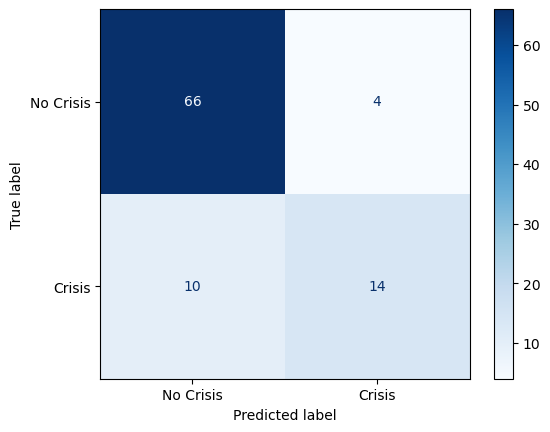

In [1598]:
# Get predicted probabilities
predicted_probs = model.predict(X)

# Convert probabilities to binary predictions (1 if probability > 0.5, else 0)
predicted_crisis = (predicted_probs > 0.5).astype(int)
# Generate the confusion matrix
cm = confusion_matrix(y, predicted_crisis)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Crisis', 'Crisis'])
disp.plot(cmap='Blues')

accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy (0.85): This shows that the model correctly predicts the outcome for 85% of the observations, which is high and suggests good overall performance.

Precision (0.78): Precision measures the percentage of correct positive predictions (true positives out of predicted positives). A precision of 0.78 indicates that the model is fairly accurate when it predicts a "crisis" but may still have some false positives.

Recall (0.58): Recall measures the model’s ability to identify actual positive cases (true positives out of actual positives). The recall of 0.58 is somewhat lower, suggesting that the model may be missing some true crises (false negatives).

Ideally, you want both precision and recall to be high for a well-balanced model, but there is often a trade-off. Given the context, consider whether it’s more critical to reduce false negatives (which would mean improving recall) or if a balanced approach is sufficient.

### ROC curve and AOC

The ROC (Receiver Operating Characteristic) curve is a tool for evaluating the performance of the logistic regression model. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity) at various threshold settings, providing insights into the trade-off between sensitivity and specificity.

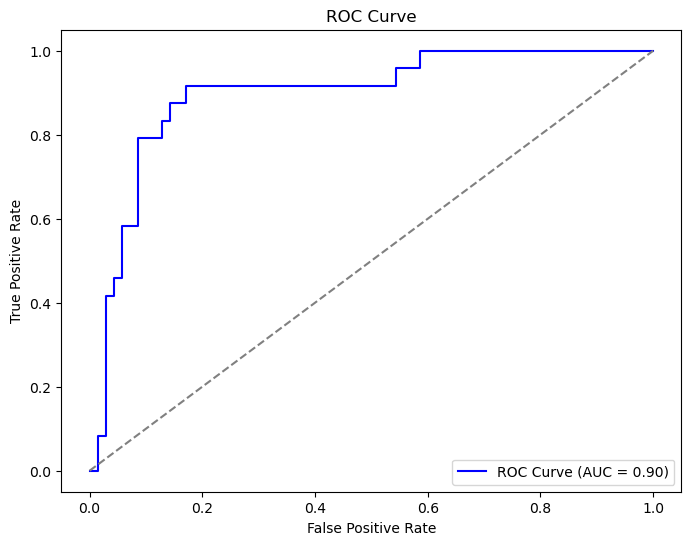

Area Under the Curve (AUC): 0.90


In [1599]:
# Get predicted probabilities for the positive class (crisis = 1)
probabilities = model.predict(X)

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Area Under the Curve (AUC): {roc_auc:.2f}')

Interpreting the ROC Curve and AUC

* ROC Curve: The closer the curve is to the top-left corner, the better the model. A curve above the diagonal line indicates better-than-random performance.

* AUC (Area Under Curve): This value ranges from 0 to 1, where 1 indicates a perfect model, 0.5 suggests a random model, and values closer to 1 indicate better predictive performance.

The Area Under the Curve (AUC) of 0.90 is excellent, indicating that the model is highly capable of distinguishing between the crisis and non-crisis cases. AUC scores closer to 1.0 indicate strong discriminatory power, so 0.90 shows the model performs well in terms of classification.

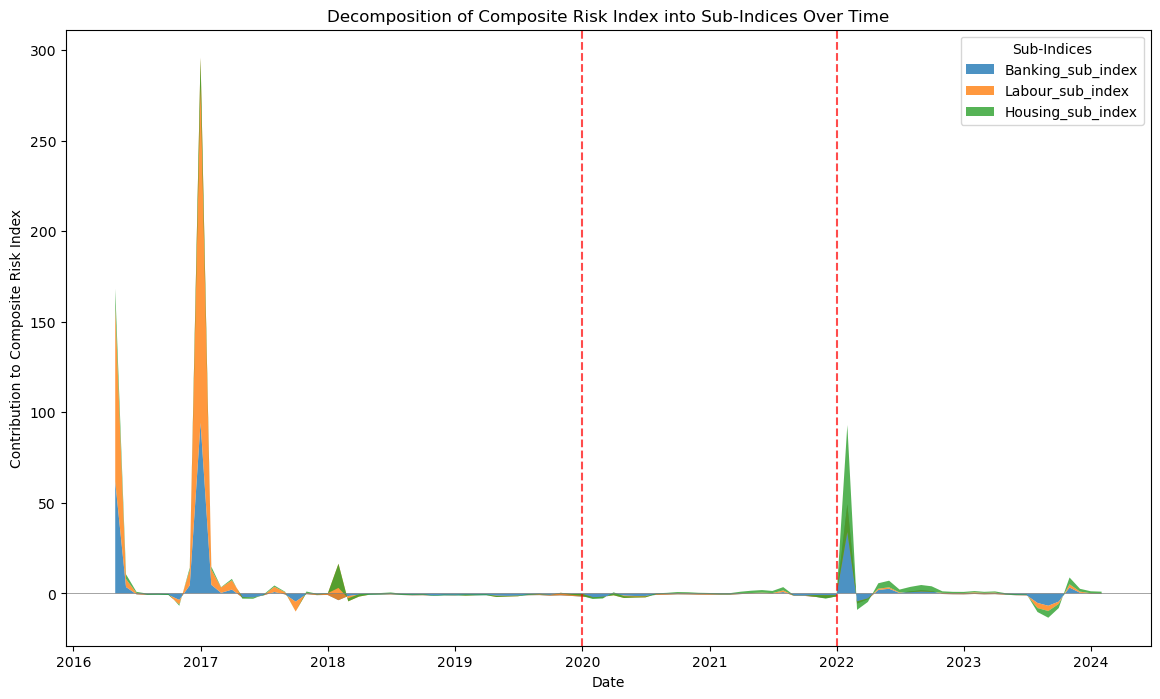

In [1600]:
df_standardized.index = pd.to_datetime(df_standardized.index).date

sub_indices = ['Banking_sub_index', 'Labour_sub_index', 'Housing_sub_index']
for index in sub_indices:
    df_standardized[f'{index}_contribution'] = df_standardized[index] / df_standardized['Principal_Component_1']

# Step 2: Set up plot
plt.figure(figsize=(14, 8))
plt.stackplot(
    df_standardized.index,
    [df_standardized[f'{index}_contribution'] for index in sub_indices],
    labels=sub_indices,
    alpha=0.8
)

plt.title('Decomposition of Composite Risk Index into Sub-Indices Over Time')
plt.xlabel('Date')
plt.ylabel('Contribution to Composite Risk Index')
plt.legend(title='Sub-Indices')
plt.axhline(0, color='gray', linewidth=0.5)

key_dates = ['2020-01-01', '2022-01-01']
for date in key_dates:
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)

plt.show()

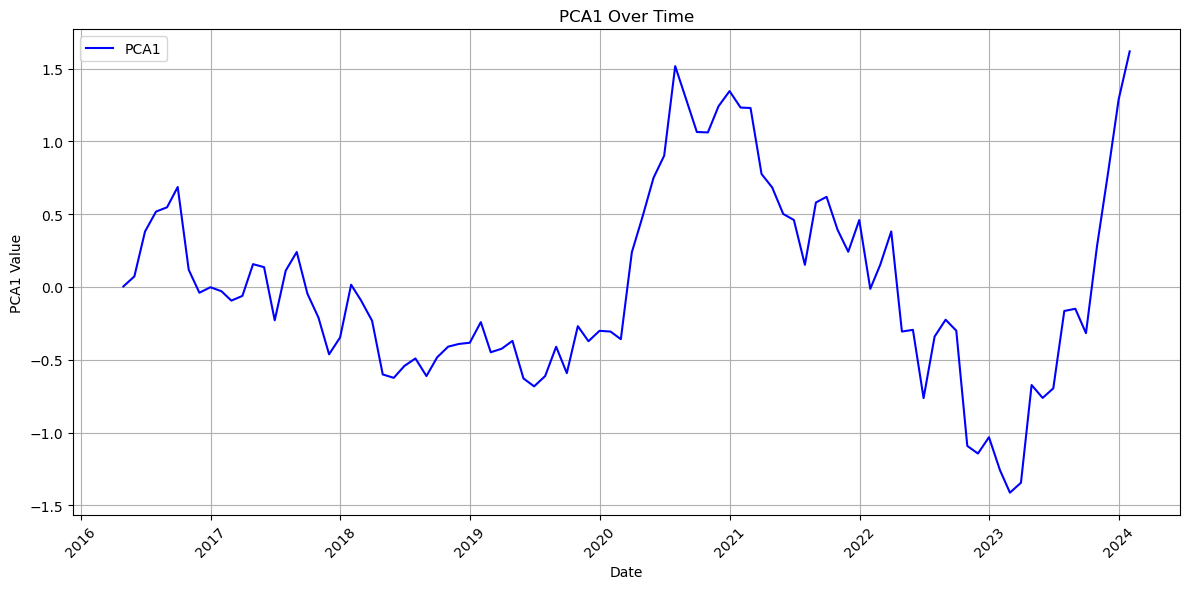

In [1601]:
# Plot PCA1 over time
plt.figure(figsize=(12, 6))
plt.plot(df_standardized.index, df_standardized['Principal_Component_1'], label='PCA1', color='blue')
plt.title('PCA1 Over Time')
plt.xlabel('Date')
plt.ylabel('PCA1 Value')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

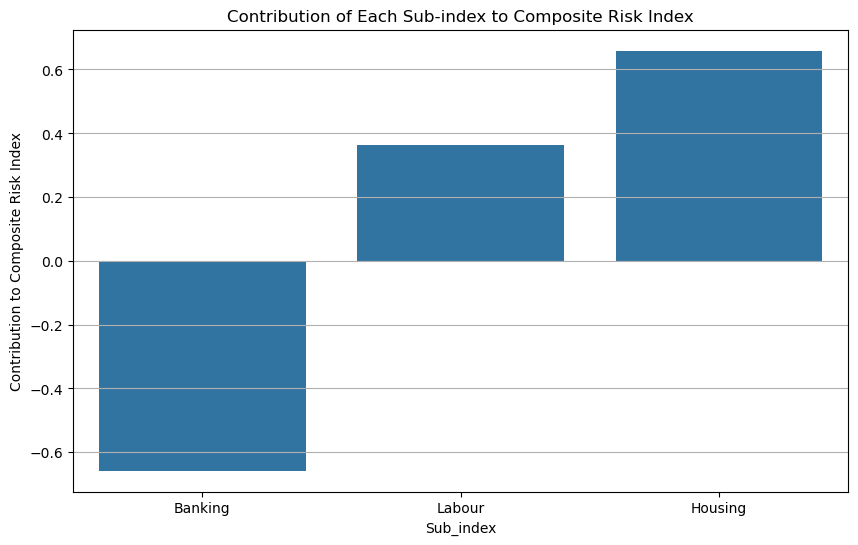

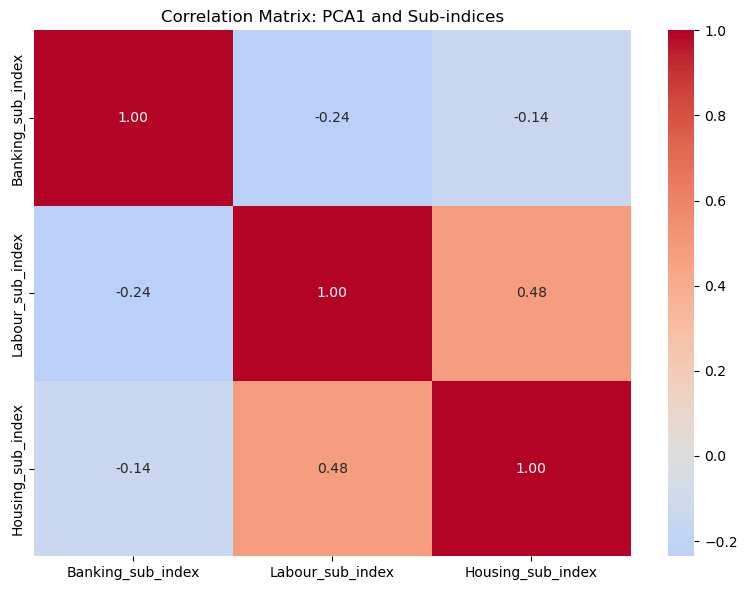

In [1602]:
pca_loadings = pca.components_[0]  # For 1 component

# Create a DataFrame for the contributions
contributions = pd.DataFrame({
    'Sub_index': ['Banking', 'Labour', 'Housing'],
    'Contribution': pca_loadings
})

# Plot contributions
plt.figure(figsize=(10, 6))
sns.barplot(x='Sub_index', y='Contribution', data=contributions)
plt.title('Contribution of Each Sub-index to Composite Risk Index')
plt.ylabel('Contribution to Composite Risk Index')
plt.grid(axis='y')
plt.show()


# Check correlation between PCA1 and original sub-indices
correlation_matrix = df_standardized[['Banking_sub_index', 'Labour_sub_index', 'Housing_sub_index']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix: PCA1 and Sub-indices')
plt.tight_layout()
plt.show()
